**Mount the Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and Configs

In [ ]:
!pip install --upgrade tensorflow -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.4 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade keras-cv -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.1 MB/s eta 0:00:00


**Imports**

In [ ]:
# Default Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

!wget -q https://storage.googleapis.com/storage.barbiero.dev/public_data_clean_balanced.npz

Using TensorFlow backend


**Randomnes and Configurations**

In [ ]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
use_tpu = True#@param {type:"boolean"}

if 'COLAB_TPU_ADDR' in os.environ and use_tpu:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
  print(TF_MASTER)
else:
  use_tpu = False


if use_tpu:
  tpu_address = TF_MASTER
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)

grpc://10.99.196.90:8470


**Defining Functions**

In [ ]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()
def plot_confusion_matrix(model, test, steps, figsize, name_jpg):
  # Compute the confusion matrix
  y_pred = model.predict(test, verbose=0, steps=steps)
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  cm = confusion_matrix(true_categories, y_pred)

  # Compute classification metrics
  accuracy = accuracy_score(true_categories, y_pred)
  precision = precision_score(true_categories, y_pred, average='macro')
  recall = recall_score(true_categories, y_pred, average='macro')
  f1 = f1_score(true_categories, y_pred, average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

#plot_images(IMGS[:25], LBLS[:25], 0, 5, 5)

# Test
def test_prediction(model, test, steps):
  y_pred = model.predict(test, verbose=0, steps=steps)
  y_pred = np.argmax(y_pred, axis=-1)
  true_categories = tf.concat([np.argmax(y, axis=-1) for x, y in test], axis=0)
  test_accuracy = accuracy_score(true_categories, y_pred)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Data Initizialization

In [ ]:
# Initializate
images, labels = np.load('public_data_clean_balanced.npz', allow_pickle=True).values()

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

Images shape:  (6120, 96, 96, 3)
Labels shape:  (6120,)


In [ ]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = labels
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val
)

y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)
y_test = tfk.utils.to_categorical(y_test, 2)

# Get the Shape of IN OUT
input_shape = X_test.shape[1:]
output_shape = y_test.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



In [ ]:
np.savez_compressed("augm_gio_split_001.npz", X_train_val, X_test, y_train_val, y_test)

In [ ]:
# create a dataset object for each set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
if use_tpu:
  BATCH_SIZE = 128
else:
  BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset
            .cache()
            .shuffle(1000, reshuffle_each_iteration=True)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_valset(dataset):
    return (
            dataset
            .cache()
            .repeat()
            .batch(BATCH_SIZE, drop_remainder=True)
        )

def prepare_testset(dataset):
    return (
            dataset
            .cache()
            .batch(BATCH_SIZE, drop_remainder=True)
        )


train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)
test_dataset = prepare_testset(test_dataset)

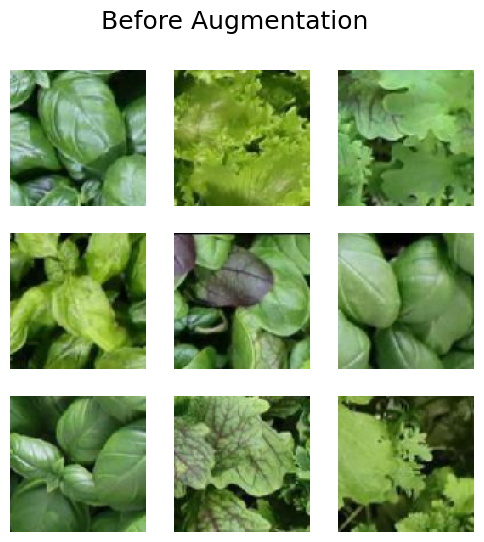

In [ ]:
visualize_dataset(train_dataset, title="Before Augmentation")

**Augmentation Layers**

Exception ignored in: <function Executor.__del__ at 0x7b6859b623b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


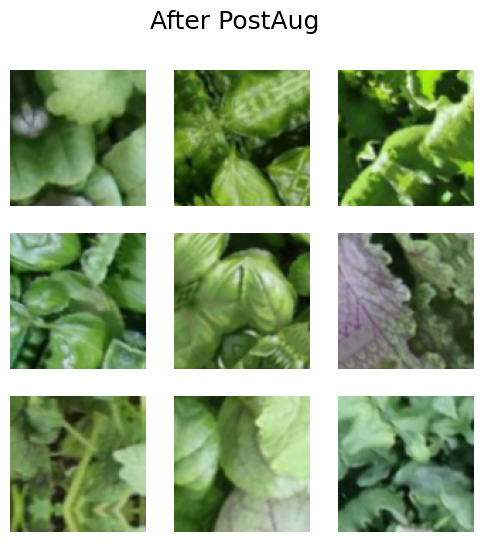

In [ ]:
aug = tfk.Sequential([
    tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
    tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
    tkl.RandomFlip(),
    tkl.RandomRotation(factor=359)
])

def apply_aug(inputs):
    inputs["images"] = aug(inputs["images"])
    return inputs

res = train_dataset.map(apply_aug, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After PostAug")

### Training

In [ ]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    train_dataset
    .map(apply_aug, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

**Define the Model**

In [ ]:
from keras.applications.inception_resnet_v2 import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  res = tfk.applications.InceptionResNetV2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
  )

  res.trainable = False
  input_layer = tkl.Input(input_shape)

  x = preprocess_input(input_layer)
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)
  x = tkl.Dropout(0.7)(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)
  model = tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
      metrics=['accuracy']
  )

  return model

if use_tpu:
  with strategy.scope():
    model = apple_elixir_model(input_shape,output_shape)
else:
  model = apple_elixir_model(input_shape,output_shape)

219055592/219055592 [==============================] - 1s 0us/step


**Train the Model**

In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

#callbacks = [early_stopping, lr_scheduler] NO NEED FOR ReduceLROnPlateau when training top
callbacks = [early_stopping]

history = model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
34/34 [==============================] - 84s 943ms/step - loss: 1.1121 - accuracy: 0.5869 - val_loss: 0.6768 - val_accuracy: 0.6836
Epoch 2/300
34/34 [==============================] - 9s 278ms/step - loss: 0.8464 - accuracy: 0.6298 - val_loss: 0.5529 - val_accuracy: 0.7370
Epoch 3/300
34/34 [==============================] - 9s 276ms/step - loss: 0.8024 - accuracy: 0.6245 - val_loss: 0.5513 - val_accuracy: 0.7383
Epoch 4/300
34/34 [==============================] - 10s 291ms/step - loss: 0.7328 - accuracy: 0.6386 - val_loss: 0.5252 - val_accuracy: 0.7474
Epoch 5/300
34/34 [==============================] - 2s 71ms/step - loss: 0.6981 - accuracy: 0.6645 - val_loss: 0.5359 - val_accuracy: 0.7383
Epoch 6/300
34/34 [==============================] - 9s 270ms/step - loss: 0.6602 - accuracy: 0.6595 - val_loss: 0.5186 - val_accuracy: 0.7591
Epoch 7/300
34/34 [==============================] - 3s 88ms/step - loss: 0.6404 - accuracy: 0.6737 - val_loss: 0.5272 - val_accuracy: 0.7422

### Saving and Plotting

In [ ]:
NAME_MODEL = "InceptionResNetV2CV_001"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Plots Loss**

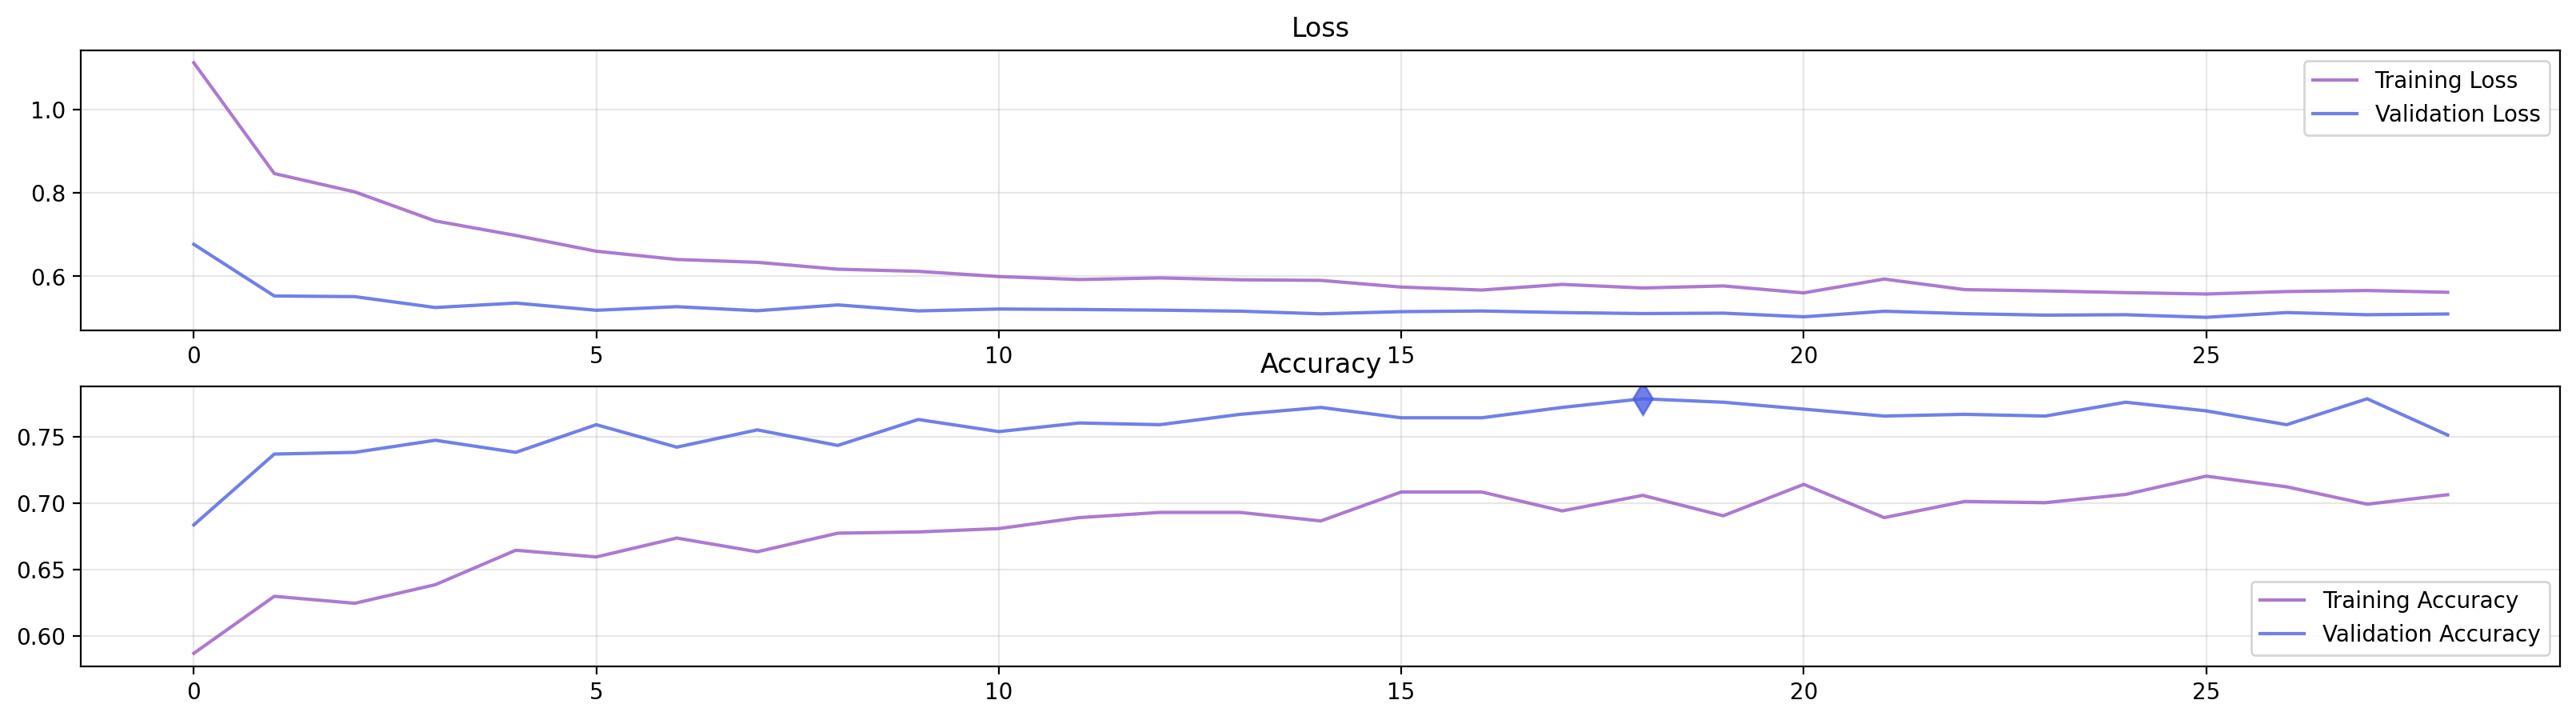

In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

Exception ignored in: <function Executor.__del__ at 0x7b6859b623b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Accuracy:	 0.7612
Precision:	 0.7629
Recall:		 0.7612
F1:		 0.7608


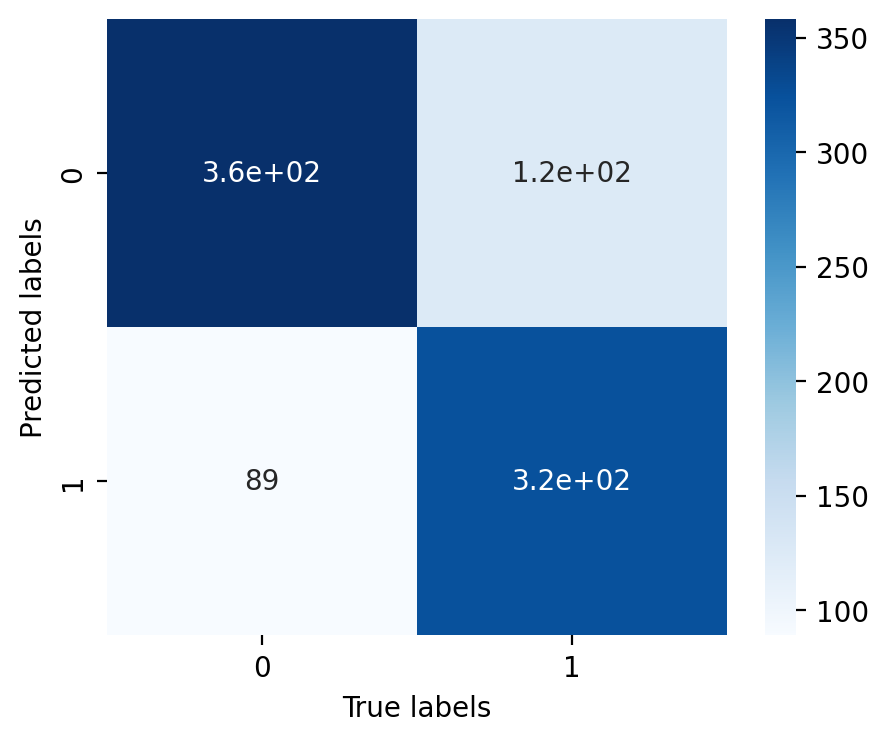

In [ ]:
plot_confusion_matrix(model, test_dataset, len(X_test) // BATCH_SIZE, (5,4), NAME_CMATRIX)

**Save the Model**

In [ ]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  model.save(NAME_MODEL, options=save_locally)
else:
  model.save(NAME_MODEL)

**Zip Model and Plots**

In [ ]:
!zip -q -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

In [ ]:
!cp {NAME_MODEL}.zip drive/MyDrive/

In [ ]:
!cp augm_gio_split_001.npz drive/MyDrive/

**Delete the Model**

In [ ]:
del model, history

## Tuning

**Load the Model**

In [ ]:
if use_tpu:
  with strategy.scope():
    load_locally = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
    ft_model = tf.keras.models.load_model(NAME_MODEL, options=load_locally)
else:
  ft_model = tfk.models.load_model(NAME_MODEL)

In [ ]:
for i, layer in enumerate(ft_model.layers):
   print(layer.name)

input_2
tf.math.truediv
tf.math.subtract
inception_resnet_v2
global_average_pooling2d
dense
dropout
dense_1


**Count the Layers**

In [ ]:
ft_model.get_layer('inception_resnet_v2').trainable = True
c = 0
for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers):
   c += 1

print("Layers: ",c)
print()

Layers:  780



**Train only the Last Layers**

In [ ]:
for i, layer in enumerate(ft_model.get_layer('inception_resnet_v2').layers[:500]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy'])

**Train the Tuning Model**

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         # Metric to monitor (validation mean squared error in this case)
    patience=5,                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.80,                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                     # Minimum learning rate
)

callbacks = [early_stopping, lr_scheduler]

history = ft_model.fit(
    train_dataset,
    epochs = 300,
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    callbacks = callbacks
).history

Epoch 1/300
34/34 [==============================] - 288s 816ms/step - loss: 0.4601 - accuracy: 0.7776 - val_loss: 3.6556 - val_accuracy: 0.5091 - lr: 0.0010
Epoch 2/300
34/34 [==============================] - 11s 331ms/step - loss: 0.4782 - accuracy: 0.7682 - val_loss: 0.6198 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 3/300
34/34 [==============================] - 5s 139ms/step - loss: 0.5094 - accuracy: 0.7546 - val_loss: 1.0348 - val_accuracy: 0.6315 - lr: 0.0010
Epoch 4/300
34/34 [==============================] - 5s 153ms/step - loss: 0.5052 - accuracy: 0.7491 - val_loss: 363.5243 - val_accuracy: 0.5130 - lr: 0.0010
Epoch 5/300
34/34 [==============================] - 11s 333ms/step - loss: 0.4723 - accuracy: 0.7691 - val_loss: 38.9279 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 6/300
34/34 [==============================] - 12s 357ms/step - loss: 0.4434 - accuracy: 0.7916 - val_loss: 2.8182 - val_accuracy: 0.8086 - lr: 0.0010
Epoch 7/300
34/34 [==============================] - 5s 

### Saving and Plotting

In [ ]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
FT_CMATRIX = NAME_CMATRIX+"_Tuning"

**Plot Loss**

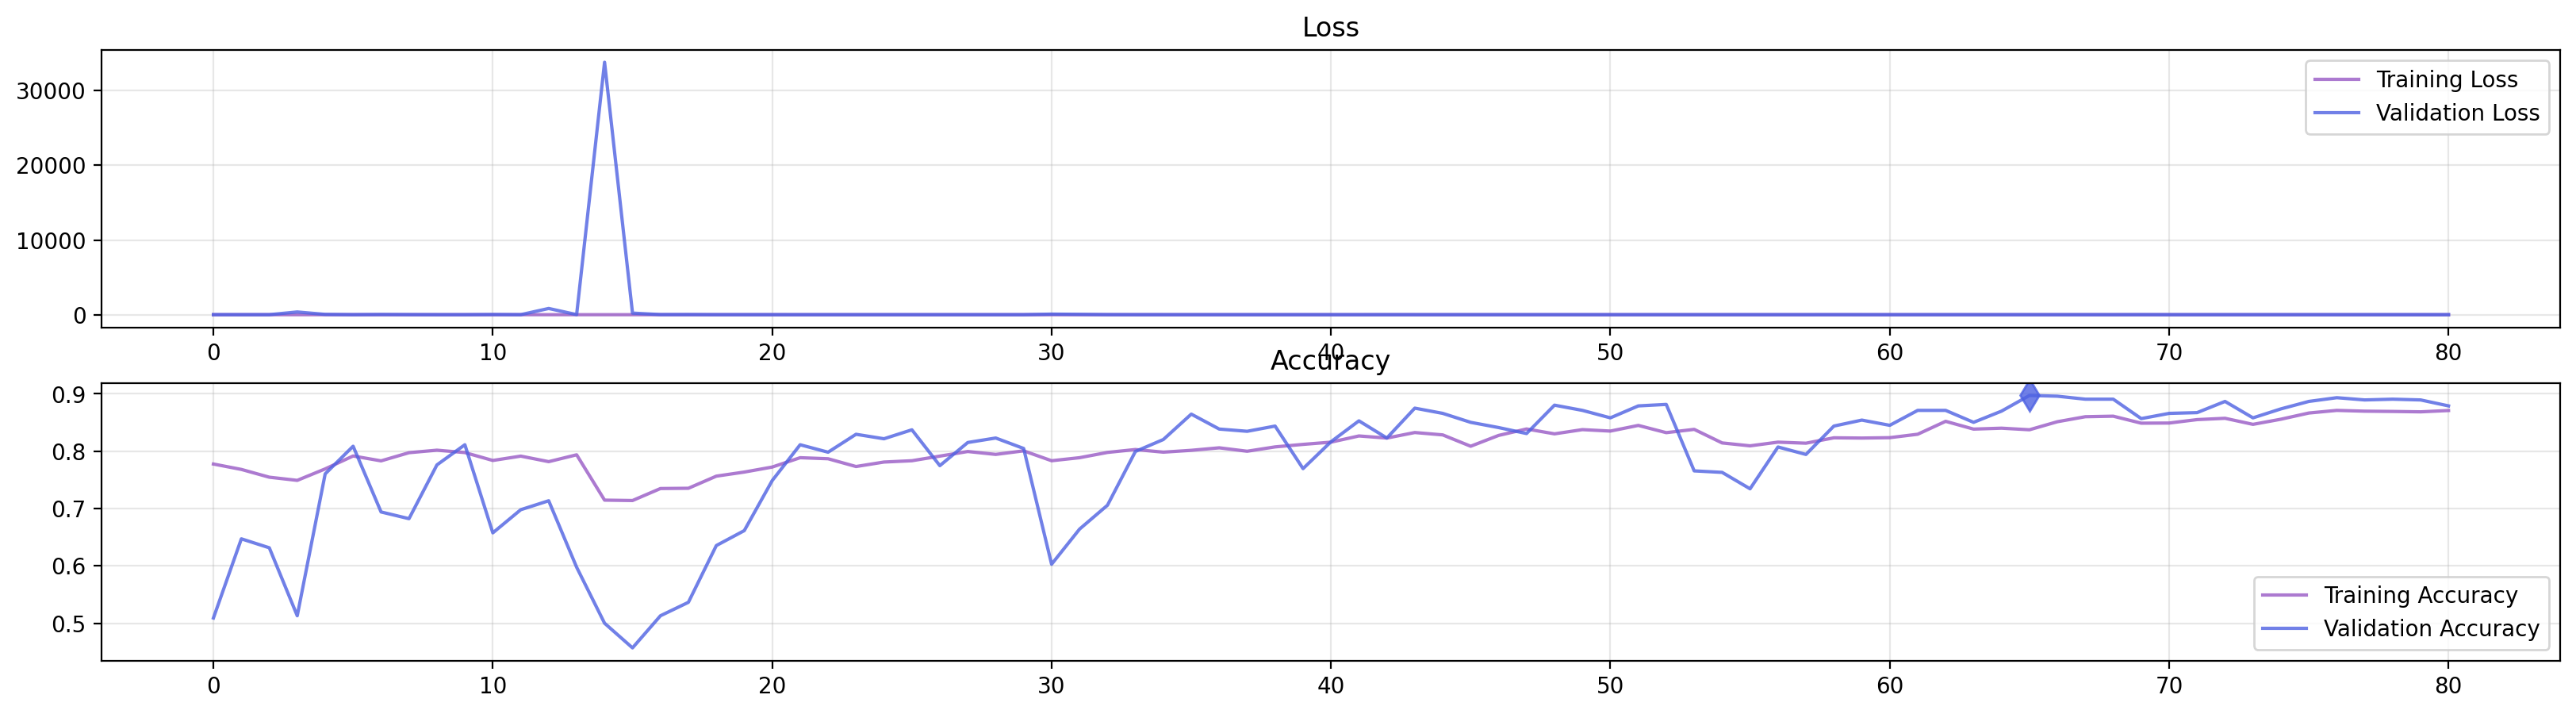

In [ ]:
plot_losses(history, (20,5), FT_PLOT)

**Plot Confusion Matrix**

Exception ignored in: <function Executor.__del__ at 0x7b6859b623b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Accuracy:	 0.8862
Precision:	 0.8862
Recall:		 0.8862
F1:		 0.8862


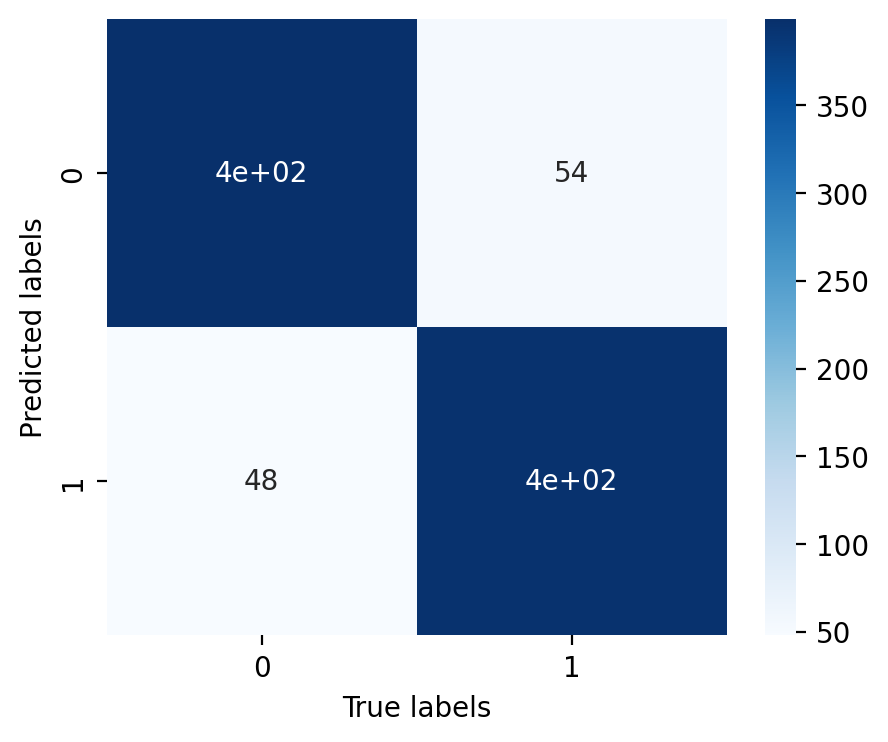

In [ ]:
plot_confusion_matrix(ft_model, test_dataset, len(X_test) // BATCH_SIZE, (5,4), FT_CMATRIX)

**Save the Model**

In [ ]:
if use_tpu:
  # save model locally from tpu using Tensorflow's "SavedModel" format
  save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
  ft_model.save(FT_NAME, options=save_locally)
else:
  ft_model.save(FT_NAME)

**Zip the Model and the Plots**

In [ ]:
!zip -q -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

  adding: InceptionResNetV2CV_001_Tuning/ (stored 0%)
  adding: InceptionResNetV2CV_001_Tuning/saved_model.pb (deflated 92%)
  adding: InceptionResNetV2CV_001_Tuning/variables/ (stored 0%)
  adding: InceptionResNetV2CV_001_Tuning/variables/variables.data-00000-of-00001 (deflated 17%)
  adding: InceptionResNetV2CV_001_Tuning/variables/variables.index (deflated 79%)
  adding: InceptionResNetV2CV_001_Tuning/assets/ (stored 0%)
  adding: InceptionResNetV2CV_001_Tuning/keras_metadata.pb (deflated 96%)
  adding: InceptionResNetV2CV_001_Tuning/fingerprint.pb (stored 0%)
  adding: InceptionResNetV2CV_001_plot_Tuning.png (deflated 13%)
  adding: InceptionResNetV2CV_001_cmatrix_Tuning.png (deflated 17%)


In [ ]:
!cp {FT_NAME}.zip drive/MyDrive/